In [2]:
!pip install -q qbstyles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

from qbstyles import mpl_style
mpl_style(dark=True)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import statsmodels.api as sm

print('imports completed — ready to load data')

imports completed — ready to load data


# Session 12 — Cardholder Study: Exercise Overview

This short exercise walks through a complete statistical workflow using the provided cardholder dataset. Follow the steps below to explore, model, and evaluate a simple logistic regression.

**Steps**

1. Load libraries
2. Load the dataset
3. Exploratory Data Analysis (EDA)
4. Prepare features and target variables
5. Fit a logistic regression model
6. Evaluate the model (LLR test, coefficients, confusion matrix, ROC / AUC)
7. Display results and create a basic prediction function


### Learning objectives

- Understand how to prepare data for a basic classification problem.
- Build and interpret a logistic regression model.
- Perform model-level (LLR) and coefficient-level hypothesis tests.
- Evaluate model performance and create a simple prediction function.


### Load data (purpose)

We will load the cardholder CSV directly from the raw GitHub URL into a pandas DataFrame. After loading we will inspect the shape, data types, first few rows and summary statistics to understand the dataset before modeling.

Checklist (manual steps):
- Load: df = pd.read_csv(url)
- Inspect: df.shape, df.info(), df.head(), df.describe()


In [3]:
url = (
    "https://raw.githubusercontent.com/Kartavya-Jharwal/Kartavya_Business_Analytics2025/"
    "main/Class_Assignments/week12/cardholderstudy.csv"
)

df = pd.read_csv(url)

print('shape:', df.shape)

df.info()

print('\nhead:')
df.head()

print('\nsummary stats:')
df.describe(include='all')

shape: (30, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Upgraded     30 non-null     int64  
 1   Purchases    30 non-null     float64
 2   Extra Cards  30 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 852.0 bytes

head:

summary stats:


,Upgraded,Purchases,Extra Cards
count,30.000000,30.000000,30.000000
mean,0.433333,34.732287,0.466667
std,0.504007,14.047128,0.507416
min,0.000000,4.874900,0.000000
25%,0.000000,26.441825,0.000000
50%,0.000000,35.214350,0.000000
75%,1.000000,42.212150,1.000000
max,1.000000,59.214600,1.000000


### Prepare features & target

Split the dataset into:

- `y` — the dependent variable (target) to predict.
- `X` — the predictor variables (features) used by the model.

Later: perform a train/test split, handle missing values, and encode/scale features if required before fitting the model.


# Automatic target / feature split — prefer 'Upgraded' when present
### If 'Upgraded' is present use it as the target; otherwise try to find a binary column (0/1) automatically


In [5]:
preferred_target = 'Upgraded'
if preferred_target in df.columns:
    target_col = preferred_target
else:
    # find binary-like columns (unique values subset of {0,1})
    candidate_cols = [col for col in df.columns if set(df[col].dropna().unique()).issubset({0, 1})]
    if candidate_cols:
        target_col = candidate_cols[0]
        print(f"Auto-selected binary-like target column: '{target_col}'")
    else:
        raise RuntimeError("No suitable binary target found. Please set `target_col` manually (e.g. 'Upgraded').")

# Create y and X
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

print(f"Target column: {target_col}")
print('X shape:', X.shape)
print('y shape:', y.shape)
print('\nTarget distribution:')
print(y.value_counts(dropna=False))

Target column: Upgraded
X shape: (30, 2)
y shape: (30,)

Target distribution:
Upgraded
0    17
1    13
Name: count, dtype: int64


# Quick EDA — preview, distributions and simple visual checks

In [6]:
print('\nValue counts (target):')
print(y.value_counts(dropna=False))

print('\nBasic stats:')
print(X.describe())



Value counts (target):
Upgraded
0    17
1    13
Name: count, dtype: int64

Basic stats:
       Purchases  Extra Cards
count  30.000000    30.000000
mean   34.732287     0.466667
std    14.047128     0.507416
min     4.874900     0.000000
25%    26.441825     0.000000
50%    35.214350     0.000000
75%    42.212150     1.000000
max    59.214600     1.000000


# Small visual checks (histograms)

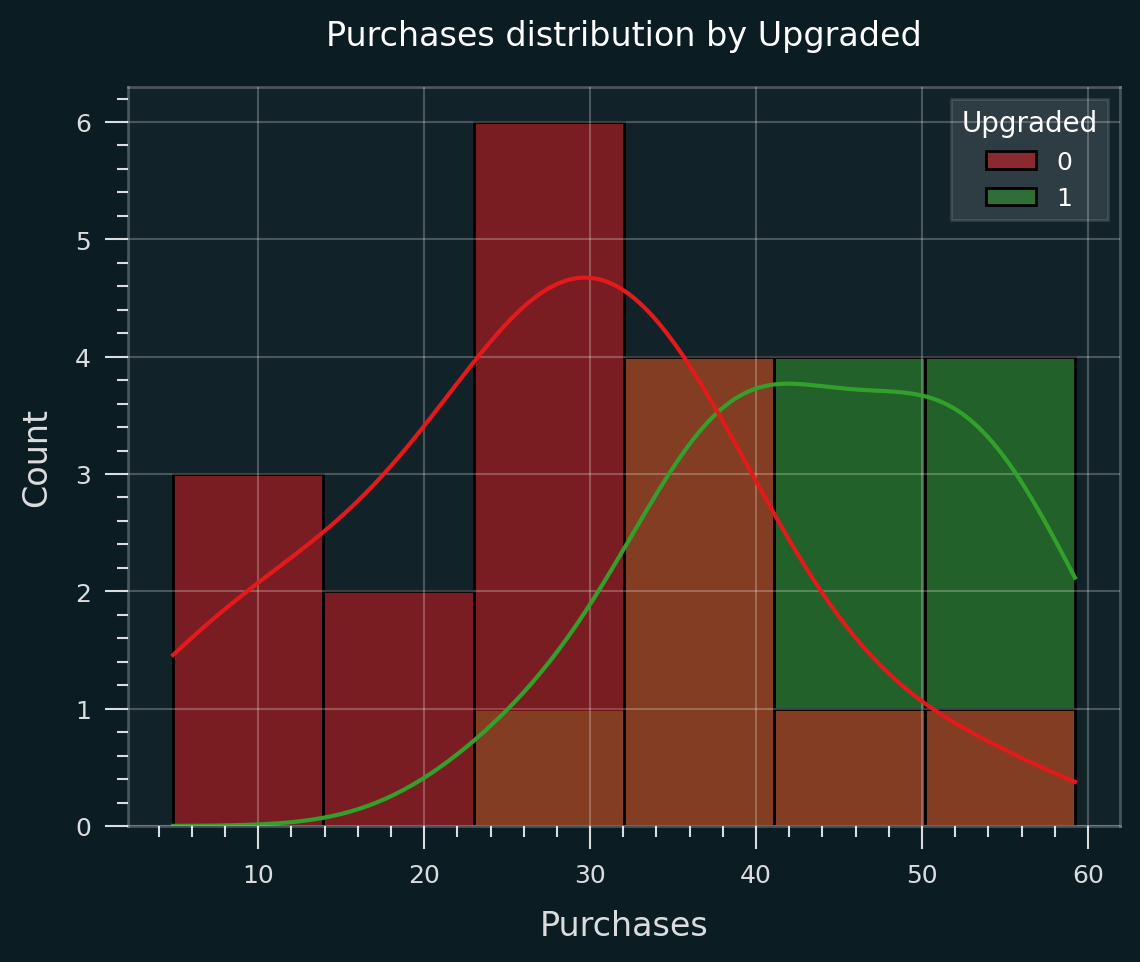

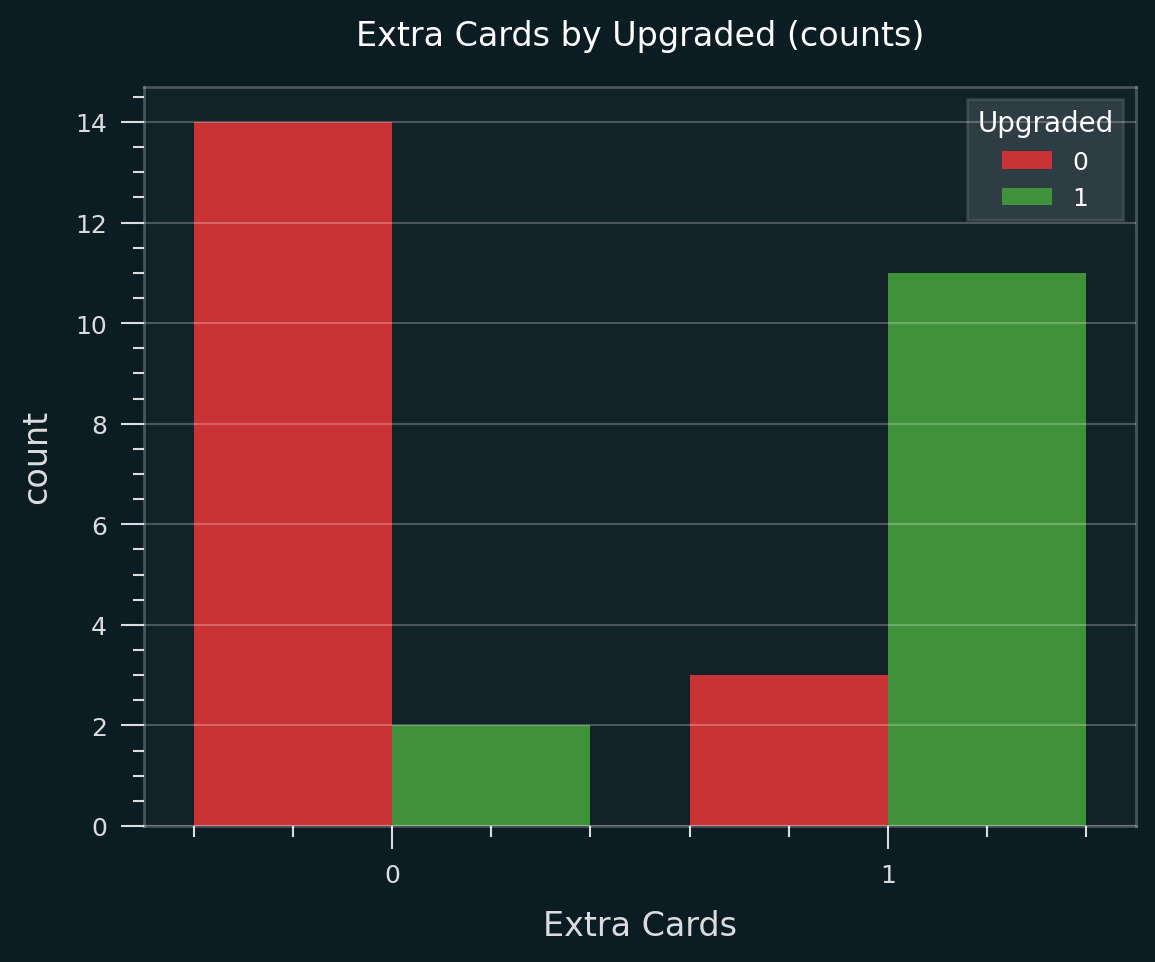

In [7]:
sns.histplot(data=df, x='Purchases', hue=target_col, kde=True)
plt.title(f"Purchases distribution by {target_col}")
plt.show()

# Relationship between Extra Cards and target (counts)
sns.countplot(data=df, x='Extra Cards', hue=target_col)
plt.title(f"Extra Cards by {target_col} (counts)")
plt.show()

### Model inference & hypothesis testing

- **LLR (Likelihood Ratio) test:** Compare the full model to a null model. Report the p-value and decide whether the model adds predictive power over the null.

- **Coefficients & interpretation:** Review estimated coefficients to understand direction (positive/negative) and relative strength of predictors.

- **Hypotheses for coefficient tests:**
  - H0: beta_i = 0 — predictor i has no relationship with the outcome.
  - H1: beta_i != 0 — predictor i is associated with the outcome.

- **T-tests / Wald tests:** Use these for individual coefficient significance; report p-values and confidence intervals for each coefficient.

- **Sample size:** This exercise uses a small sample (≈30 cases). Interpret p-values cautiously — emphasise effect sizes and confidence intervals as well.


### Fit logistic regression (no train/test split)

In this step we fit a logistic regression model using the full dataset (no train/test split requested).

We will:
- Add an intercept term to X and fit a statsmodels Logit model to predict `Upgraded`.
- Print the Logit fit summary (coefficients, p-values).
- Create predicted probabilities and predicted labels (threshold = 0.5) and attach them to the DataFrame.

> Note: Because we are using all data for training and prediction there is a risk of overfitting — this is an instructional demonstration only.

In [8]:
# Prepare X with constant and fit statsmodels Logit on the full dataset
import statsmodels.api as sm

# Ensure X is ready (if any non-numeric columns exist they'd need encoding here).
X_const = sm.add_constant(X)

logit_model = sm.Logit(y, X_const)
logit_result = logit_model.fit(disp=0)  # disp=0 suppresses iterative output when run

# Print the model summary (Logit / GLM-style output)
print(logit_result.summary())

# Add predictions (probabilities and binary prediction) to df
# Predicted probability of Upgraded == 1
df['pred_prob'] = logit_result.predict(X_const)
# Predicted label using 0.5 threshold
df['pred_label'] = (df['pred_prob'] >= 0.5).astype(int)

# Show a small sample of predictions and counts
print('\nPrediction counts:')
print(df['pred_label'].value_counts())

# Optionally show classification metrics on the same data (no train/test split — instructional only)
from sklearn.metrics import confusion_matrix, classification_report
print('\nConfusion matrix on full data:')
print(confusion_matrix(y, df['pred_label']))
print('\nClassification report on full data:')
print(classification_report(y, df['pred_label']))

                           Logit Regression Results                           
Dep. Variable:               Upgraded   No. Observations:                   30
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                  0.5110
Time:                        15:01:55   Log-Likelihood:                -10.038
converged:                       True   LL-Null:                       -20.527
Covariance Type:            nonrobust   LLR p-value:                 2.785e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.9398      2.947     -2.355      0.019     -12.716      -1.163
Purchases       0.1395      0.068      2.049      0.040       0.006       0.273
Extra Cards     2.7743      1.193      2.326    

In [9]:
# sklearn LogisticRegression on full data (no train/test split)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# If features require scaling, do so — here only 'Purchases' is numeric; Extra Cards is numeric (0/1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = LogisticRegression(max_iter=200, solver='lbfgs')
clf.fit(X_scaled, y)

# Coefficients and intercept
coef = pd.Series(clf.coef_[0], index=X.columns)
intercept = clf.intercept_[0]
print('Intercept:', intercept)
print('\nCoefficients:')
print(coef)

# Predictions on full data
pred_prob_sk = clf.predict_proba(X_scaled)[:, 1]
df['pred_prob_sk'] = pred_prob_sk
df['pred_label_sk'] = (df['pred_prob_sk'] >= 0.5).astype(int)

# Metrics on full data (training metrics — no split)
print('\nAccuracy:', accuracy_score(y, df['pred_label_sk']))
print('ROC AUC:', roc_auc_score(y, pred_prob_sk))
print('\nConfusion matrix (sklearn)')
print(confusion_matrix(y, df['pred_label_sk']))
print('\nClassification report (sklearn)')
print(classification_report(y, df['pred_label_sk']))

Intercept: -0.5264885383676431

Coefficients:
Purchases      1.170278
Extra Cards    1.051274
dtype: float64

Accuracy: 0.7666666666666667
ROC AUC: 0.918552036199095

Confusion matrix (sklearn)
[[13  4]
 [ 3 10]]

Classification report (sklearn)
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.71      0.77      0.74        13

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.76        30
weighted avg       0.77      0.77      0.77        30



### Evaluation grid — metrics + confusion matrices (seaborn)

Below we'll compute three key classification metrics (accuracy, precision, recall) and show the confusion matrix. The display uses a small grid so you can compare the two model outputs side-by-side.

We expect these columns to be available after running previous cells:
- `df['pred_label']` (predictions from statsmodels Logit)
- `df['pred_label_sk']` (predictions from sklearn LogisticRegression)

All metrics below are computed on the full dataset (no train/test split) — this is training-set evaluation only.

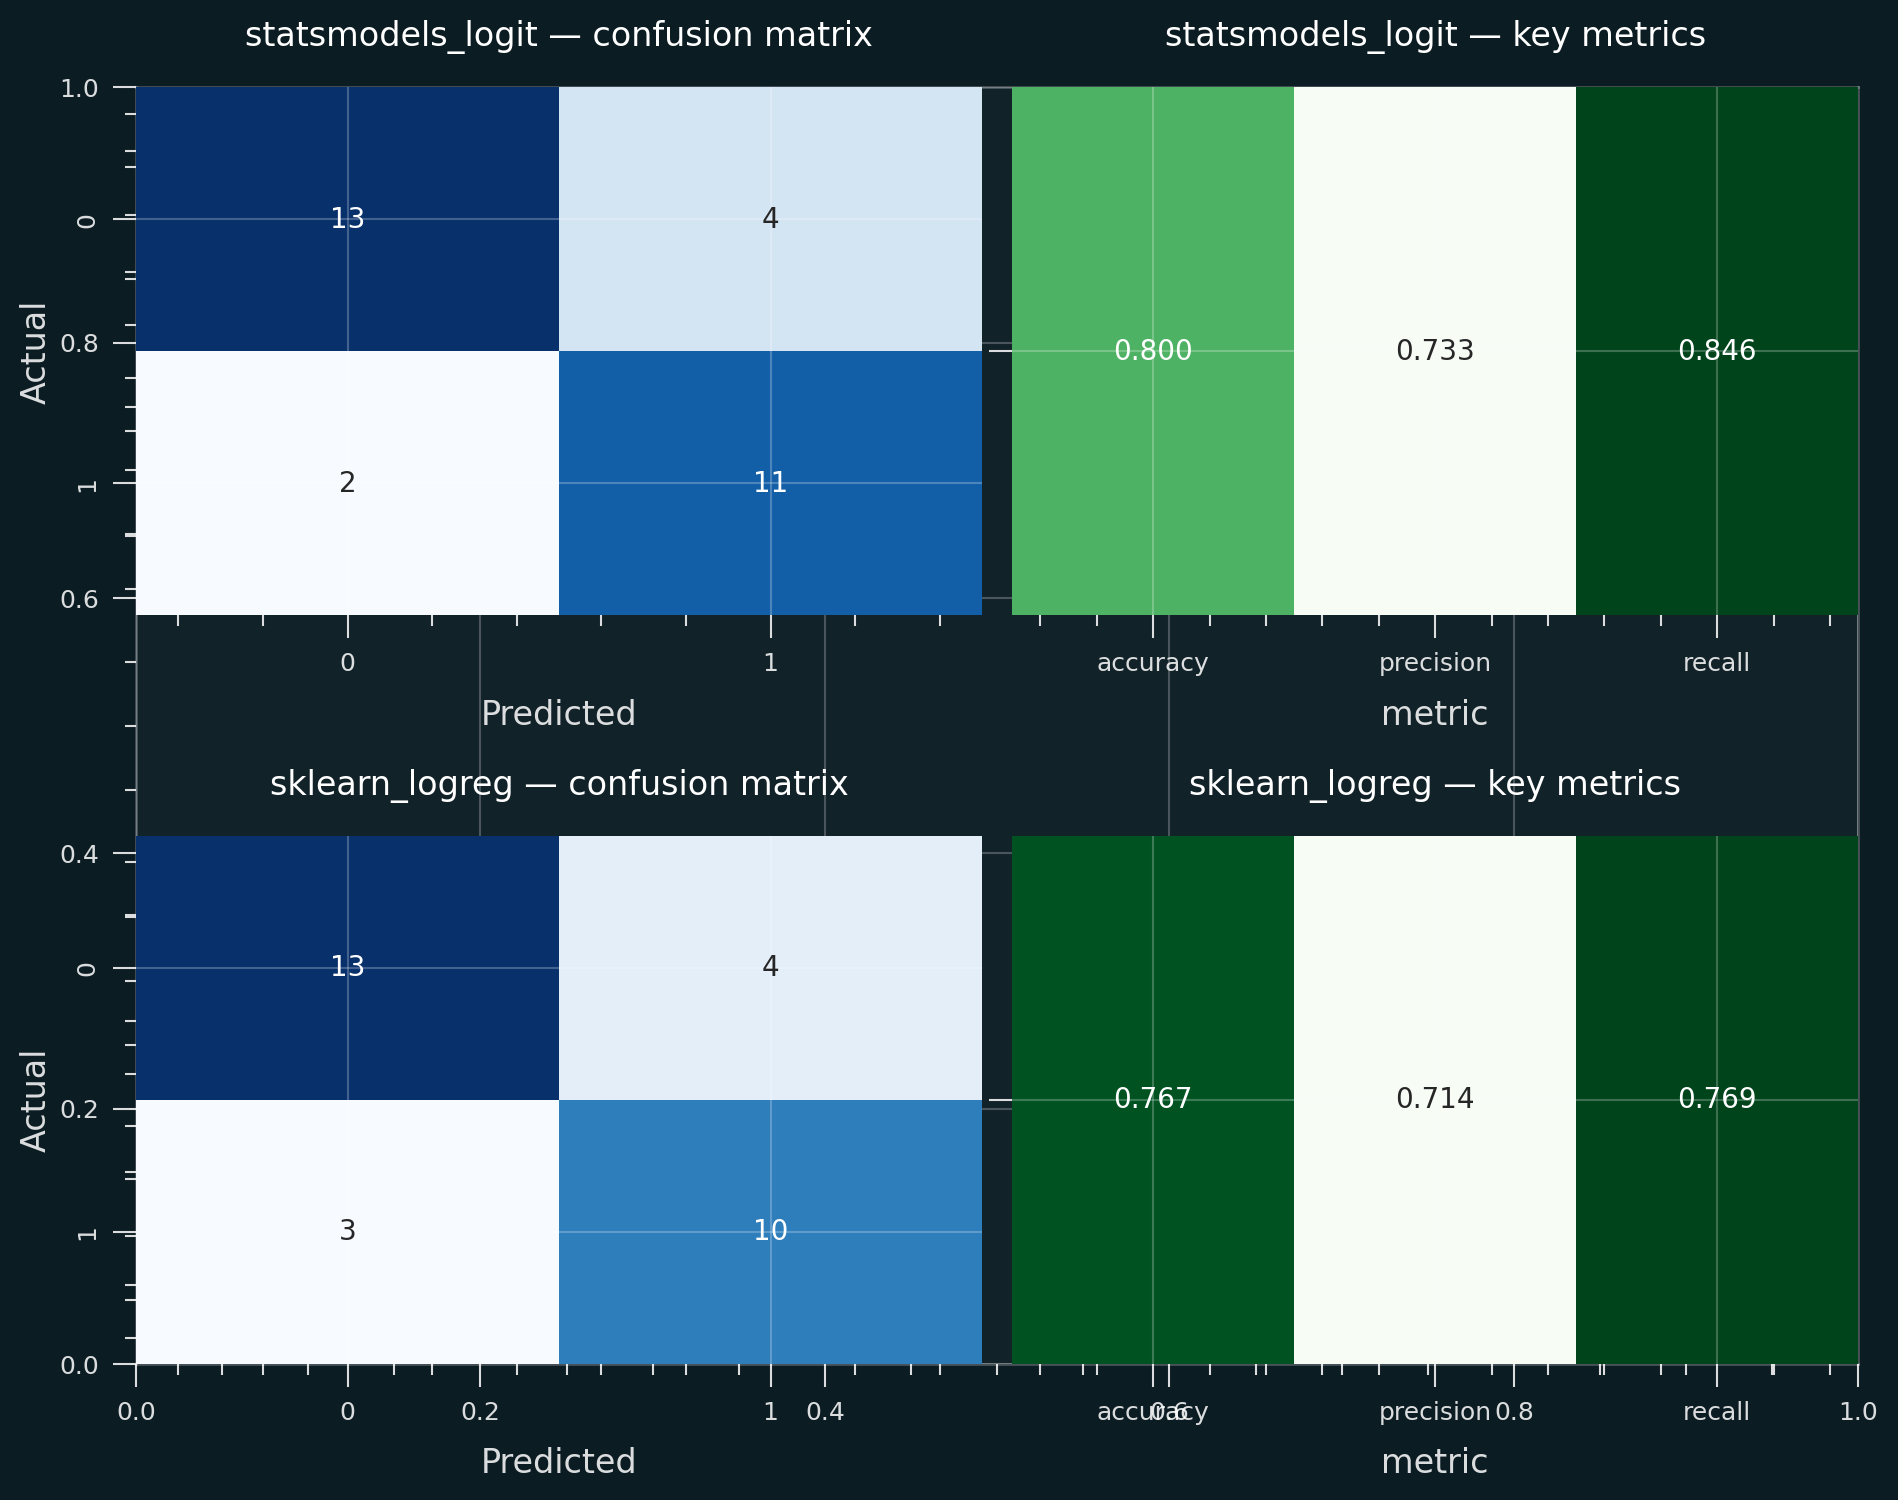

In [10]:
# Build an evaluation grid showing confusion matrix and (accuracy, precision, recall)
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Specify models to evaluate — only include columns that exist
models = {
    'statsmodels_logit': 'pred_label',
    'sklearn_logreg': 'pred_label_sk'
}

existing_models = {k: v for k, v in models.items() if v in df.columns}
if not existing_models:
    raise RuntimeError('No prediction columns found (expected pred_label or pred_label_sk). Run the model cells first.')

n_models = len(existing_models)
fig, axes = plt.subplots(nrows=n_models, ncols=2, figsize=(10, 4 * n_models))

if n_models == 1:
    axes = [axes]

for i, (name, col) in enumerate(existing_models.items()):
    # Confusion matrix
    cm = confusion_matrix(y, df[col])
    ax_cm = axes[i][0] if n_models > 1 else axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_cm)
    ax_cm.set_title(f'{name} — confusion matrix')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('Actual')

    # Metrics
    acc = accuracy_score(y, df[col])
    prec = precision_score(y, df[col], zero_division=0)
    rec = recall_score(y, df[col], zero_division=0)

    metrics_df = pd.DataFrame({'metric': ['accuracy', 'precision', 'recall'], 'value': [acc, prec, rec]})
    metrics_df = metrics_df.set_index('metric')

    ax_m = axes[i][1] if n_models > 1 else axes[1]
    sns.heatmap(metrics_df.T, annot=True, fmt='.3f', cmap='Greens', cbar=False, ax=ax_m)
    ax_m.set_title(f'{name} — key metrics')
    ax_m.set_yticklabels([])

plt.tight_layout()
plt.show()